In [14]:
import gymnasium as gym
import torch

import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import deque

import numpy as np
from collections import namedtuple

In [15]:
class DQN(torch.nn.Module):
    def __init__(self, n_state, n_action, n_hidden):
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(n_state, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden, n_action)

    def forward(self, state):
        res = self.layer1(state)
        res = torch.nn.functional.relu(res)
        res = self.layer2(res)
        return res


In [16]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return torch.tensor(random.randint(0, n_action - 1), dtype=torch.long)
        else:
            with torch.no_grad():
                q_values = estimator(state)
            return torch.tensor(torch.argmax(q_values), dtype=torch.long).detach()
    return policy_function

In [17]:
class Parameters():
    def __init__(self
                 , episode_count = 1
                 , batch_size = 1
                 , epsilone = 0.1
                 , epsilone_min = 0.01
                 , epsilon_decay = 1.
                 , gamma = 1.
                 , tau = 0.001
                                        ):
        self.episode_count = episode_count
        self.batch_size = batch_size
        self.epsilone = epsilone
        self.epsilone_min = epsilone_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.memlength = episode_count
        self.tau = tau

    def update_epsilone(self):
        self.epsilon = max(self.epsilone * self.epsilon_decay, self.epsilone_min)

In [18]:
env = gym.envs.make("LunarLander-v2")

In [19]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'is_done'))

In [20]:
def step_optimize(params, memory, policy_agent, target_agent, optimizer):
    if (len(memory) < params.batch_size):
        return 
    
    # получаем случайный батч из буффера
    batch = random.sample(memory, params.batch_size)


    q_value_t0 = torch.zeros(params.batch_size)
    q_value_t1 = torch.zeros(params.batch_size)
    batch_num = 0
    
    # Получаем Q значения при заданном дествии из текущего состояния  Q(t0,a)
    # использекум агент политики
    for state, action, next_state, reward, is_done in batch:
        q_value = policy_agent(state)
        q_value_t0[batch_num] = q_value[action]


        # Получаем Q значения из состояния полученного после действия Q(t1,a)
        # выбираем максимальное Q значение (r + g * Qmax)
        # использекум целевой агент

        if is_done == False:
            q_value_next = target_agent(next_state)
            max_v_num = torch.argmax(q_value_next).item()
            q_value_t1[batch_num] = q_value_next[max_v_num] * params.gamma + reward
            
        batch_num = batch_num + 1

    

    # Объединяем все в общий лосс
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(q_value_t0, q_value_t1)

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_agent.parameters(), 100)
    
    optimizer.step()

    

In [21]:
def model_learning(params, memory, policy_agent, target_agent, optimizer, action_count, total_reward_episode):

    for episode in tqdm(range(params.episode_count)):

        policy = gen_epsilon_greedy_policy(policy_agent, params.epsilone, action_count)
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        is_done = False
        is_break = False

        while not is_done and not is_break:
            # получаем действие из агента политики
            action = policy(state)
            next_state, reward, is_done, is_break, _ = env.step(action.item())

            total_reward_episode[episode] += reward

            next_state = torch.tensor(next_state, dtype=torch.float32)
            reward = torch.tensor(reward, dtype=torch.float32)

            # записываем результаты в буффер
            memory.append(Transition(state, action, next_state, reward, (is_done or is_break)))

            state = next_state

            step_optimize(params, memory, policy_agent, target_agent, optimizer)

            # делаем "мягкое" обновление весов
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_agent.state_dict()
            policy_net_state_dict = policy_agent.state_dict()

            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*params.tau + target_net_state_dict[key]*(1-params.tau)
            target_agent.load_state_dict(target_net_state_dict)

        params.update_epsilone()

In [22]:
# параметры обучения
params = Parameters(episode_count=500, 
                    batch_size=64, 
                    epsilone=0.9, 
                    epsilone_min=0.05, 
                    epsilon_decay=0.99, 
                    gamma=0.99,
                    tau=0.005)



seed = 42
# количство последних эпизодов для отчета
last_episode = 100
# суммарная награда за каждый эпизод
total_reward_episode = [0]*params.episode_count

memory_length = 10000
# количество нейронов в скытом слое
n_hidden = 64

lr=0.0001

# количество дествий модели
action_count = env.action_space.n
# количество параметров описывающее моментальное состояние модели
state_count = env.observation_space.shape[0]


# Агент политики и целевой агент
policy_agent = DQN(state_count, action_count, n_hidden)
target_agent = DQN(state_count, action_count, n_hidden)

# Подгрузить в целевую сеть коэффициенты из сети политики
target_agent.load_state_dict(policy_agent.state_dict())

# Задать оптимайзер
optimizer = torch.optim.AdamW(policy_agent.parameters(), lr=lr, amsgrad=True)

# Буффер исходных состояний действий состояний поле действий и наград
memory = deque(maxlen=memory_length)


model_learning(params, memory, policy_agent, target_agent, optimizer, action_count, total_reward_episode)


  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\v.tyumenev\AppData\Local\Temp\ipykernel_22576\2329595665.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.argmax(q_values), dtype=torch.long).detach()
100%|██████████| 500/500 [28:32<00:00,  3.42s/it] 


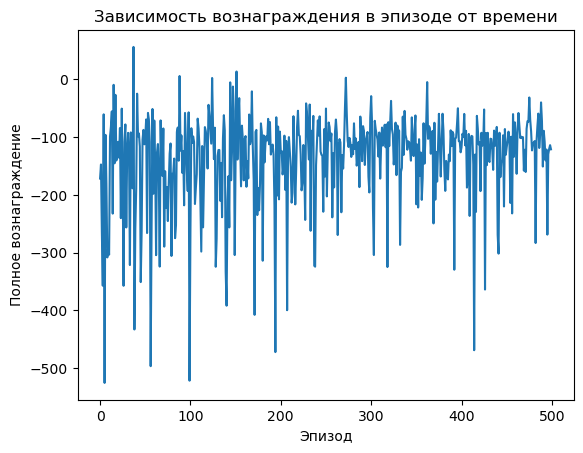

In [26]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [24]:
reward_end_episode = total_reward_episode[-last_episode:]
sum(reward_end_episode)/last_episode

-126.5069282403869

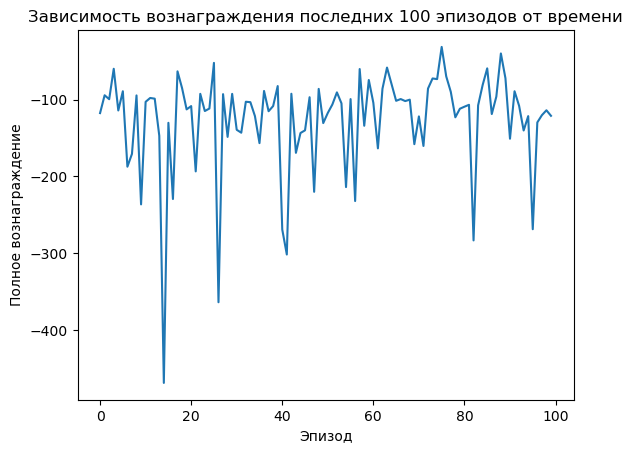

In [25]:
plt.plot(reward_end_episode)
plt.title('Зависимость вознаграждения последних {} эпизодов от времени'.format(last_episode))
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()